In [30]:
%matplotlib inline
from read_db import read_db

from sklearn.cross_validation import train_test_split,cross_val_score
from sklearn.svm import SVC
from scipy.sparse import csr_matrix
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.learning_curve import learning_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [31]:
weather, running, full, stat= read_db()

In [32]:
stat.iloc[:,2:].head(3)

,date,max_tempf,mean_tempf,min_tempf,max_dew_pointf,mean_dew_pointf,min_dew_pointf,max_hum,mean_hum,min_hum,...,mean_wind_speed,max_gust_speed,precipitationIn,cloudcover,events,wind_dir_degrees,city,city_code,dayofweek,count
0,2010-02-08,33,28.0,22,11,10,9,62,49,35,...,16,35.0,0.00,3,None,295,"Boston, MA",1,0,1
1,2010-04-14,66,53.0,40,38,23,11,86,49,12,...,8,29.0,0.00,1,None,283,"Boston, MA",1,2,1
2,2010-05-01,71,64.0,56,48,34,25,60,42,23,...,7,26.0,0.00,5,None,141,"Boston, MA",1,5,1


In [33]:
stat.iloc[:,2:].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6557 entries, 0 to 6556
Data columns (total 27 columns):
date                          6557 non-null datetime64[ns]
max_tempf                     6557 non-null int64
mean_tempf                    6556 non-null float64
min_tempf                     6557 non-null int64
max_dew_pointf                6557 non-null int64
mean_dew_pointf               6557 non-null int64
min_dew_pointf                6557 non-null int64
max_hum                       6557 non-null int64
mean_hum                      6557 non-null int64
min_hum                       6557 non-null int64
max_sea_level_pressure_in     6557 non-null float64
mean_sea_level_pressure_in    6557 non-null float64
min_sea_level_pressure_in     6557 non-null float64
max_visibility_miles          6557 non-null int64
mean_visibility_miles         6557 non-null int64
min_visibility_miles          6557 non-null int64
max_wind_speed                6557 non-null int64
mean_wind_speed           

In [34]:
datasets=stat.iloc[:,2:]
datasets['events']=datasets['events'].fillna(value = 'Clear')
# datasets['id'] = datasets['events'].fillna(value = 'Clear').astype('category').cat.codes
dummies_condition = pd.get_dummies(datasets['events'],prefix='condition')
dummies_dayofweek = pd.get_dummies(datasets['dayofweek'],prefix='dayofweek')
datasets['precipitationIn']=datasets['precipitationIn'].replace('T',0).astype(float)
datasets = pd.concat([datasets, dummies_condition, dummies_dayofweek], axis=1)
datasets=datasets.drop('max_gust_speed',1)

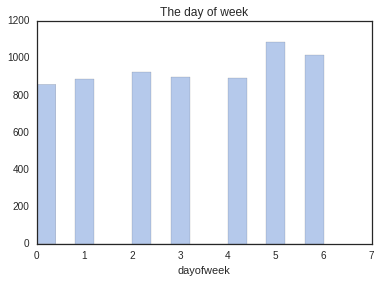

In [35]:
sns.distplot(datasets['dayofweek'].dropna(), color="b", hist = True, kde = False)
sns.plt.title('The day of week')

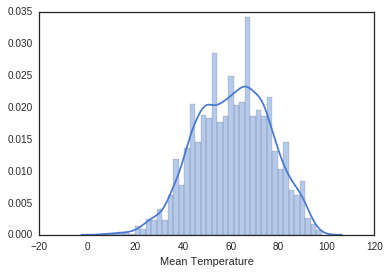

In [36]:
# Plot mean_tempf counts
sns.distplot(datasets['mean_tempf'].dropna(), color="b", hist = True)
plt.xlabel('Mean Temperature')

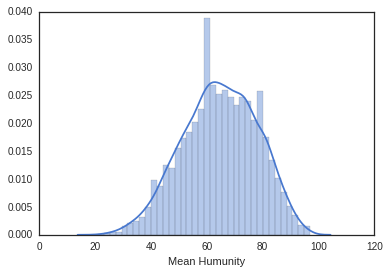

In [37]:
sns.distplot(datasets['mean_hum'].dropna(), color="b", hist = True)
plt.xlabel('Mean Humunity')

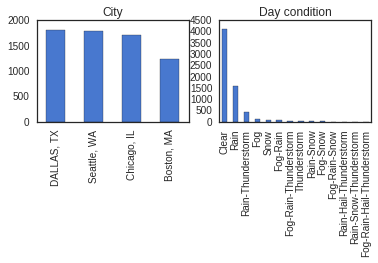

In [38]:
# Set up a grid of plots
fig = plt.figure() 
fig_dims = (2, 2)

# Plot city counts
plt.subplot2grid(fig_dims, (0, 0))
datasets['city'].value_counts().plot(kind='bar', 
                                       title='City')


# Plot events counts
plt.subplot2grid(fig_dims, (0, 1))
datasets['events'].fillna(value = 'Clear').value_counts().plot(kind='bar', 
                                       title='Day condition')

In [39]:
datasets=datasets.drop(['dayofweek','city','date','events'],1)

In [40]:
datasets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6557 entries, 0 to 6556
Data columns (total 43 columns):
max_tempf                               6557 non-null int64
mean_tempf                              6556 non-null float64
min_tempf                               6557 non-null int64
max_dew_pointf                          6557 non-null int64
mean_dew_pointf                         6557 non-null int64
min_dew_pointf                          6557 non-null int64
max_hum                                 6557 non-null int64
mean_hum                                6557 non-null int64
min_hum                                 6557 non-null int64
max_sea_level_pressure_in               6557 non-null float64
mean_sea_level_pressure_in              6557 non-null float64
min_sea_level_pressure_in               6557 non-null float64
max_visibility_miles                    6557 non-null int64
mean_visibility_miles                   6557 non-null int64
min_visibility_miles                    6557 

In [41]:
datasets.dropna().info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6556 entries, 0 to 6556
Data columns (total 43 columns):
max_tempf                               6556 non-null int64
mean_tempf                              6556 non-null float64
min_tempf                               6556 non-null int64
max_dew_pointf                          6556 non-null int64
mean_dew_pointf                         6556 non-null int64
min_dew_pointf                          6556 non-null int64
max_hum                                 6556 non-null int64
mean_hum                                6556 non-null int64
min_hum                                 6556 non-null int64
max_sea_level_pressure_in               6556 non-null float64
mean_sea_level_pressure_in              6556 non-null float64
min_sea_level_pressure_in               6556 non-null float64
max_visibility_miles                    6556 non-null int64
mean_visibility_miles                   6556 non-null int64
min_visibility_miles                    6556 

In [42]:
datasets=datasets.dropna()

---------
The total sample size for figure 1 is
6556
---------
The total sample size for figure 2 is
6066
---------
The total sample size for figure 3 is
6066
---------
The total sample size for figure 4 is
6066


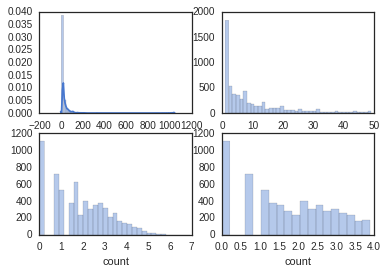

In [44]:
import seaborn as sns

# Set up a grid of plots
fig = plt.figure() 
fig_dims = (2, 2)

# Plot day of week counts
plt.subplot2grid(fig_dims, (0, 0))

sns.set(style="white", palette="muted", color_codes=True)
sns.distplot(datasets['count'], color="b")
print'---------'
print'The total sample size for figure 1 is'
print(len(datasets['count']))

plt.subplot2grid(fig_dims, (0, 1))

sns.set(style="white", palette="muted", color_codes=True)
sns.distplot(datasets['count'][datasets['count']<50],kde=False, color="b")
print'---------'
print'The total sample size for figure 2 is'
print(len(datasets['count'][datasets['count']<50]))

plt.subplot2grid(fig_dims, (1, 0))

sns.set(style="white", palette="muted", color_codes=True)
sns.distplot(np.log(datasets['count']),kde=False, color="b")
print'---------'
print'The total sample size for figure 3 is'
print(len(datasets['count'][datasets['count']<50]))

plt.subplot2grid(fig_dims, (1, 1))

sns.set(style="white", palette="muted", color_codes=True)
sns.distplot(np.log(datasets['count'][datasets['count']<50]),kde=False, color="b")
print'---------'
print'The total sample size for figure 4 is'
print(len(datasets['count'][datasets['count']<50]))

In [45]:
reduced = datasets[datasets['count']<50]
X=reduced.drop(['count','city_code'],1)

In [46]:
reduced['outdoor'] = reduced['count'].map(lambda x: 1 if x>5 else 0)
y=reduced['outdoor']

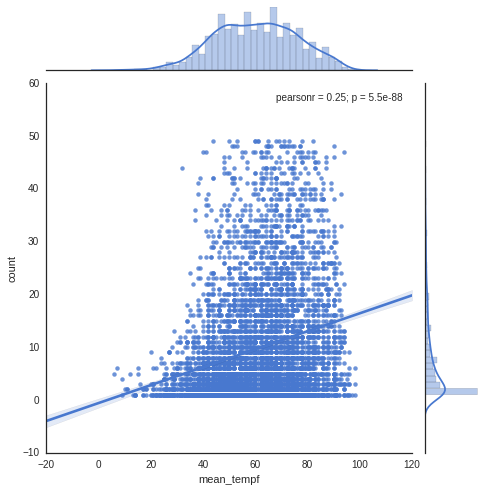

In [47]:
# sns.regplot(x="mean_tempf", y="count", data=datasets)
sns.jointplot("mean_tempf", "count", data=reduced, kind="reg",
                  color="b", size=7)

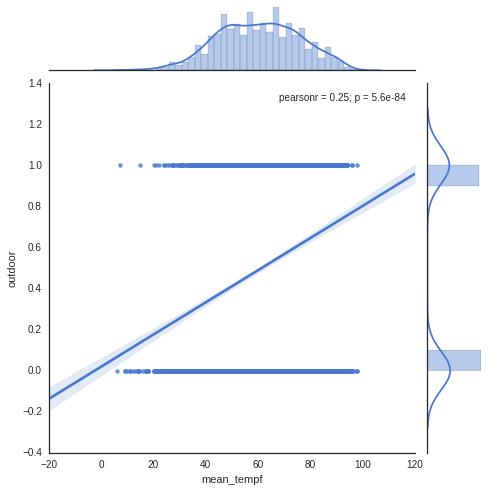

In [57]:
sns.jointplot("mean_tempf", "outdoor", data=reduced, kind="reg",
                  color="b", size=7)

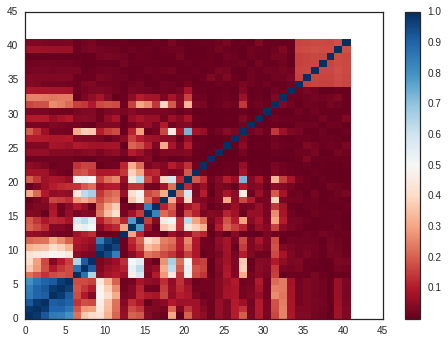

In [48]:
plt.pcolor(np.abs(np.corrcoef(X.T)), cmap='RdBu')
plt.colorbar()

In [49]:
print(len(y))

6066


In [50]:
print(y.value_counts())

0    3089
1    2977
Name: outdoor, dtype: int64


In [51]:
X_norm_nocat = (X-np.mean(X, axis=0))/np.std(X, axis=0)
X_train,X_test,y_train,y_test=train_test_split(X_norm_nocat,y,test_size = 0.25,random_state = 6)

In [ ]:
forest = RandomForestClassifier(n_estimators=200,max_depth=10)

forest.fit(X_train,y_train)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.barh(range(X_train.shape[1]), importances[indices],
         color="r", xerr=std[indices], align='center')
plt.yticks(range(X_train.shape[1]), indices)
plt.ylim([-1, X_train.shape[1]])

In [23]:
X[[0,1,8,19,7,2,4,3,10]].head(1)

,max_tempf,mean_tempf,min_hum,wind_dir_degrees,mean_hum,min_tempf,mean_dew_pointf,max_dew_pointf,mean_sea_level_pressure_in
0,33,28.0,35,295,49,22,10,11,29.77


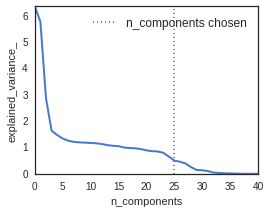

In [25]:
model = LogisticRegression()

pca = PCA()
pipe = Pipeline(steps=[('pca', pca), ('logistic', model)])

pca.fit(X_train)

plt.figure(1, figsize=(4, 3))
plt.clf()
plt.plot(pca.explained_variance_, linewidth=2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_')

###############################################################################
# Prediction

n_components = [1,5,10,15,20,25,30]
Cs = np.logspace(-4, 4, 3)

#Parameters of pipelines can be set using ‘__’ separated parameter names:

estimator = GridSearchCV(pipe,
                         dict(pca__n_components=n_components,
                              logistic__C=Cs))
estimator.fit(X_train, y_train)

plt.axvline(estimator.best_estimator_.named_steps['pca'].n_components,
            linestyle=':', label='n_components chosen')
plt.legend(prop=dict(size=12))
plt.show()

In [56]:
names = ["Nearest Neighbors","Logistic regression", "Linear SVM", "RBF SVM", "Decision Tree",
         "Random Forest", "AdaBoost", "Naive Bayes", "Linear Discriminant Analysis",
         "Quadratic Discriminant Analysis"]
classifiers = [
    KNeighborsClassifier(n_neighbors = 1),
    LogisticRegression(),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    DecisionTreeClassifier(),
    RandomForestClassifier(n_estimators=400,max_depth=10),
    AdaBoostClassifier(n_estimators=400),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis()]

for name, clf in zip(names, classifiers):
        clf.fit(X_train, y_train)
        score = cross_val_score(clf, X_train, y_train, cv=10)
        testscore=clf.score(X_test,y_test)
        print(name)
        print np.mean(score), np.std(score)
        print(testscore)

Nearest Neighbors
0.604306615403 0.0181969160685
0.593276203032
Logistic regression
0.648057956226 0.0214006200609
0.660514172709
Linear SVM
0.635742023646 0.0171794385972
0.654581410679
RBF SVM
0.568484809109 0.0166202843637
0.573500329598
Decision Tree
0.596389711996 0.0176399186317
0.623599208965
Random Forest
0.665412378795 0.0182241051388
0.680949241925
AdaBoost
0.638375033653 0.0166655969254
0.648648648649
Naive Bayes
0.5069274338 0.0107615422658
0.515491100857
Linear Discriminant Analysis
0.646737824738 0.0212929237784
0.659195781147
Quadratic Discriminant Analysis
0.501871512057 0.00946596505145
0.50560316414


In [58]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.grid_search import RandomizedSearchCV

model = RandomForestClassifier()

param_grid = {

"n_estimators": np.arange(50,510,50)

}

cvmodel = RandomizedSearchCV(model, param_distributions = param_grid,  cv=10, n_jobs=-1)

cvmodel.fit(X_train, y_train)

score = cross_val_score(cvmodel.best_estimator_, X_train, y_train, cv=10)

print np.mean(score), np.std(score)

print(cvmodel.best_estimator_.score(X_test,y_test))

0.672008689973 0.0224933566147
0.697429136454


In [59]:
cvmodel.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=450, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

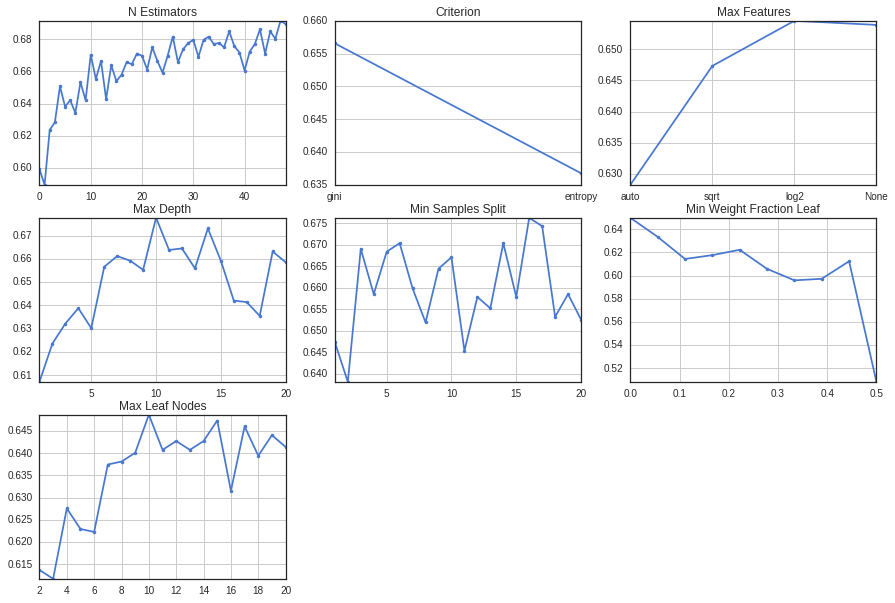

In [66]:
plt.figure(figsize=(15,10))

#N Estimators
plt.subplot(3,3,1)
feature_param = range(1,50)
scores=[]
for feature in feature_param:
    clf = RandomForestClassifier(n_estimators=feature)
    clf.fit(X_train,y_train)
    scoreCV = clf.score(X_test,y_test)
    scores.append(scoreCV)
plt.plot(scores, '.-')
plt.axis('tight')
# plt.xlabel('parameter')
# plt.ylabel('score')
plt.title('N Estimators')
plt.grid();

#Criterion
plt.subplot(3,3,2)
feature_param = ['gini','entropy']
scores=[]
for feature in feature_param:
    clf = RandomForestClassifier(criterion=feature)
    clf.fit(X_train,y_train)
    scoreCV = clf.score(X_test,y_test)
    scores.append(scoreCV)
plt.plot(scores, '.-')
# plt.xlabel('parameter')
# plt.ylabel('score')
plt.title('Criterion')
plt.xticks(range(len(feature_param)), feature_param)
plt.grid();

#Max Features
plt.subplot(3,3,3)
feature_param = ['auto','sqrt','log2',None]
scores=[]
for feature in feature_param:
    clf = RandomForestClassifier(max_features=feature)
    clf.fit(X_train,y_train)
    scoreCV = clf.score(X_test,y_test)
    scores.append(scoreCV)
plt.plot(scores, '.-')
plt.axis('tight')
# plt.xlabel('parameter')
# plt.ylabel('score')
plt.title('Max Features')
plt.xticks(range(len(feature_param)), feature_param)
plt.grid();

#Max Depth
plt.subplot(3,3,4)
feature_param = range(1,21)
scores=[]
for feature in feature_param:
    clf = RandomForestClassifier(max_depth=feature)
    clf.fit(X_train,y_train)
    scoreCV = clf.score(X_test,y_test)
    scores.append(scoreCV)
plt.plot(feature_param, scores, '.-')
plt.axis('tight')
# plt.xlabel('parameter')
# plt.ylabel('score')
plt.title('Max Depth')
plt.grid();

#Min Samples Split
plt.subplot(3,3,5)
feature_param = range(1,21)
scores=[]
for feature in feature_param:
    clf = RandomForestClassifier(min_samples_split =feature)
    clf.fit(X_train,y_train)
    scoreCV = clf.score(X_test,y_test)
    scores.append(scoreCV)
plt.plot(feature_param, scores, '.-')
plt.axis('tight')
# plt.xlabel('parameter')
# plt.ylabel('score')
plt.title('Min Samples Split')
plt.grid();

#Min Weight Fraction Leaf
plt.subplot(3,3,6)
feature_param = np.linspace(0,0.5,10)
scores=[]
for feature in feature_param:
    clf = RandomForestClassifier(min_weight_fraction_leaf =feature)
    clf.fit(X_train,y_train)
    scoreCV = clf.score(X_test,y_test)
    scores.append(scoreCV)
plt.plot(feature_param, scores, '.-')
plt.axis('tight')
# plt.xlabel('parameter')
# plt.ylabel('score')
plt.title('Min Weight Fraction Leaf')
plt.grid();

#Max Leaf Nodes
plt.subplot(3,3,7)
feature_param = range(2,21)
scores=[]
for feature in feature_param:
    clf = RandomForestClassifier(max_leaf_nodes=feature)
    clf.fit(X_train,y_train)
    scoreCV = clf.score(X_test,y_test)
    scores.append(scoreCV)
plt.plot(feature_param, scores, '.-')
plt.axis('tight')
# plt.xlabel('parameter')
# plt.ylabel('score')
plt.title('Max Leaf Nodes')
plt.grid();

In [80]:
clf = RandomForestClassifier(n_estimators=200,max_depth = 10)
clf.fit(X_train, y_train)
score = cross_val_score(clf, X_train, y_train, cv=10)
testscore=clf.score(X_test,y_test)
print np.mean(score), np.std(score)
print testscore

0.660578167292 0.0229434867479
0.6783124588
